
<center>

#**Trabajo 2:** Predicción de la accidentalidad

</center>
<center>

---
Fundamentos de Analitica


---
**Profesor:**

Juan David Ospina Arango

---
**Integrantes:**

Maria Camila Durango Munoz

Danilo Giraldo López

Cristian Jaramillo Herrera

Juan Felipe Usuga Villegas
</center>

In [51]:
!pip install --upgrade pip
!pip install pandas==1.5.3 seaborn==0.12.2 matplotlib==3.7.1

In [52]:
# Importamos las librerias necesarias.
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Limpieza de datos

In [53]:
# Cargamos la data en la variable df.
df = pd.read_csv('/content/incidentes_viales.csv', delimiter=';')

<ipython-input-53-553e48cecddb>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/incidentes_viales.csv', delimiter=';')


In [54]:
print("La cantidad de filas que tenemos es:", df.shape[0],
      "\nY la cantidad de columnas es:", df.shape[1],
      "\n\nLas primeras columnas de nuestro data set nos arrojan la siguiente información:")

df.head()

La cantidad de filas que tenemos es: 270765 
Y la cantidad de columnas es: 18 

Las primeras columnas de nuestro data set nos arrojan la siguiente información:


,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DIRECCION ENCASILLADA,DISEÑO,EXPEDIENTE,FECHA_ACCIDENTE,FECHA_ACCIDENTES,GRAVEDAD_ACCIDENTE,MES,NRO_RADICADO,NUMCOMUNA,BARRIO,COMUNA,LOCATION,X,Y
0,2015,1013,Caida Ocupante,CR 46 CL 43,CR 046 043 000 00000,Tramo de via,A000259731,21/10/2015 05:58:00,2015-10-21T10:58:00.000Z,Con heridos,10,1508668,10,Barrio Colón,La Candelaria,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,Choque,CR 43 A CL 29,CR 043 A 029 000 00000,Tramo de via,A000261725,05/11/2015 03:00:00,2015-11-05T08:00:00.000Z,Solo daños,11,1510621,10,San Diego,La Candelaria,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,Otro,CR 46 CL 37,CR 046 037 000 00000,Tramo de via,A000259739,21/10/2015 07:40:00,2015-10-21T12:40:00.000Z,Con heridos,10,1508691,02,La Francia,Santa Cruz,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,Atropello,CR 34 CL 112,CR 034 112 000 00000,Tramo de via,A000259752,21/10/2015 12:00:00,2015-10-21T17:00:00.000Z,Con heridos,10,1508694,01,Santo Domingo Savio No. 1,Popular,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,Choque,CR 50 CL 14,CR 050 014 000 00000,Tramo de via,A000259949,03/11/2015 06:16:00,2015-11-03T11:16:00.000Z,Solo daños,11,1510634,15,Santa Fé,Guayabal,"[-75.578180998, 6.21699243701]",833903.11,1179469.60


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270765 entries, 0 to 270764
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AÑO                    270765 non-null  object 
 1   CBML                   252609 non-null  object 
 2   CLASE_ACCIDENTE        270759 non-null  object 
 3   DIRECCION              270765 non-null  object 
 4   DIRECCION ENCASILLADA  270374 non-null  object 
 5   DISEÑO                 269617 non-null  object 
 6   EXPEDIENTE             270655 non-null  object 
 7   FECHA_ACCIDENTE        270765 non-null  object 
 8   FECHA_ACCIDENTES       270765 non-null  object 
 9   GRAVEDAD_ACCIDENTE     270765 non-null  object 
 10  MES                    270765 non-null  int64  
 11  NRO_RADICADO           270760 non-null  object 
 12  NUMCOMUNA              270765 non-null  object 
 13  BARRIO                 251759 non-null  object 
 14  COMUNA                 257967 non-nu

Con lo anterior podemos darnos cuenta que tenemos varios datos faltantes en las siguientes columnas:

- CBML = Codigo catastral que corresponde al codigo comuna, barrio, manzana, lote catastral de un predio.
- CLASE_ACCIDENTE = Clasificación del IPAT sobre la clase de accidente de transito: choque, atropello, volcamiento, caida de ocupante, incendio, u otro (que no corresponde a las anteriores 5 clasificaciones, p. ej: sumersión)
- DIRECCION ENCASILLADA = Dirección encasillada que entrega el geocodificador
- DISEÑO = Sitio de la vía donde ocurrió el accidente: Cicloruta, Glorieta, Interseccion, Lote o Predio, Paso a Nivel, Paso Elevado, Paso Inferior, Pontón, Puente, Tramo de via, Tunel, Via peatonal
- EXPEDIENTE = Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
- NRO_RADICADO = Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
- BARRIO = Barrio de ocurrencia del incidente vial
- COMUNA = Denominación con la cual se identifica cada Comuna o Corregimiento. 01:Popular 02:Santa Cruz 03:Manrique 04:Aranjuez 05:Castilla 06:Doce de Octubre 07:Robledo 08:Villa Hermosa 09:Buenos Aires 10:La Candelaria 11:Laureles - Estadio 12:La América 13:San Javier 14:El Poblado 15:Guayabal 16:Belén 50:San Sebastián de Palmitas 60:San Cristobal 70:Altavista 80:San Antonio de Prado 90:Santa Elena 99:Toda la Ciudad

In [56]:
df.dtypes

AÑO                       object
CBML                      object
CLASE_ACCIDENTE           object
DIRECCION                 object
DIRECCION ENCASILLADA     object
DISEÑO                    object
EXPEDIENTE                object
FECHA_ACCIDENTE           object
FECHA_ACCIDENTES          object
GRAVEDAD_ACCIDENTE        object
MES                        int64
NRO_RADICADO              object
NUMCOMUNA                 object
BARRIO                    object
COMUNA                    object
LOCATION                  object
X                        float64
Y                        float64
dtype: object

In [57]:
# Validación de valores nulos
null = df.isnull().sum()
nullTable = pd.DataFrame({'Columna': df.columns, 'Valores nulos': null})
nullTable = nullTable.reset_index(drop=True)
nullTable

,Columna,Valores nulos
0,AÑO,0
1,CBML,18156
2,CLASE_ACCIDENTE,6
3,DIRECCION,0
4,DIRECCION ENCASILLADA,391
5,DISEÑO,1148
6,EXPEDIENTE,110
7,FECHA_ACCIDENTE,0
8,FECHA_ACCIDENTES,0
9,GRAVEDAD_ACCIDENTE,0


Ahora que no tenemos nulos, vamos a validar los valores duplicados que podemos tener.

In [58]:
# Validación de duplicados
duplicates = df.duplicated().sum()
duplicatesTable = pd.DataFrame({'Columna': df.columns, 'Duplicados': duplicates})
duplicatesTable

,Columna,Duplicados
0,AÑO,3
1,CBML,3
2,CLASE_ACCIDENTE,3
3,DIRECCION,3
4,DIRECCION ENCASILLADA,3
5,DISEÑO,3
6,EXPEDIENTE,3
7,FECHA_ACCIDENTE,3
8,FECHA_ACCIDENTES,3
9,GRAVEDAD_ACCIDENTE,3


Cómo tenemos varios valores nulos y algunos duplicados, vamos a sacarlos del data set con la siguiente celda.

In [59]:
# Eliminamos nulos
df.dropna(inplace=True)

# Eliminamos duplicados
df.drop_duplicates(inplace=True)

Ya que no tenemos duplicados, vamos a empezar a validar los valores de las columnas que tenemos.

## Año

In [60]:
df['AÑO'].unique()

array(['2015', '2014', '2016', '2017', '2018', '2019\\r', '2019', '2020',
       2020, 2015, 2014, 2016, 2017, 2018], dtype=object)

Como vemos tenemos diversos valores para el mismo año, con ello en mente vamos a convertir la columna "AÑO" a tipo de datos string y luego vamos a extraer los primeros cuatro caracteres (que representan el año).

In [61]:
df["AÑO"] = df["AÑO"].apply(lambda x : re.findall(r"[0-9]{4}",str(x))[0])
df["AÑO"].unique()

array(['2015', '2014', '2016', '2017', '2018', '2019', '2020'],
      dtype=object)

## CBML

In [62]:
df["CBML"].unique()

array(['1013', '1020', '0205', '0101', '1504', '1417', '1105', '1009',
       '1018', '0705', '0605', '1012', '0410', '0908', '0512', '0516',
       '0911', '1116', '0905', '8000', '1419', '1415', '0405', '1502',
       '0701', '1114', '0517', '1307', '0508', '0210', '0809', '1019',
       '1113', '1102', '1612', '1010', '0815', '0712', '1017', '0511',
       '0301', '1204', '0608', '0707', '1422', '0202', '1005', '1511',
       '0103', '0207', '0718', '1423', '1004', '0802', '1006', '1110',
       '1003', '0913', '0914', '0912', '1509', '0105', '1608', '0801',
       '0709', '1507', '1103', '0402', '0505', '1603', '0415', '1014',
       '1421', '1414', '1510', '0509', '0303', '0602', '0305', '1602',
       '0606', '0401', '0607', '1610', '1101', '0209', '7001', '1309',
       '1107', '1001', '1016', '1310', '0514', '0507', '1506', '1111',
       '1615', '0417', '0804', '1503', '1404', '1108', '0412', '0413',
       '0717', '0907', '0703', '1015', '6098', '0601', '1211', '1008',
      

En este caso para CBML no se denota un patron que podamos utilizar para eliminar datos que no nos aporte, así que no le realizaremos ninguna manipulación.

## CLASE_ACCIDENTE

In [63]:
df["CLASE_ACCIDENTE"].unique()

array(['Caida Ocupante', 'Choque', 'Otro', 'Atropello', 'Volcamiento',
       'Caída de Ocupante', 'Incendio'], dtype=object)

Cómo podemos ver tenemos registros con "Caída de Ocupante", vamos a reemplazar esto con "Caida de Ocupante" y vamos a pasar todas las opciones a minuscula.

In [64]:
df["CLASE_ACCIDENTE"] = df["CLASE_ACCIDENTE"].apply(lambda x : str(x).replace("Caída de Ocupante","Caida Ocupante").lower())

df["CLASE_ACCIDENTE"].unique()

array(['caida ocupante', 'choque', 'otro', 'atropello', 'volcamiento',
       'incendio'], dtype=object)

## DIRECCION

Validadremos un ejemplo de 20 registros tomados al azar para validar las direcciones.

In [65]:
df["DIRECCION"].sample(20)

179216    CR 65 CL 56 A
104598    CR 73 CL 47 D
155707       CR 50 CL 2
186700      CL 82 CR 51
85192     CR 65 F CL 25
106218    CL 46 CR 16 E
169249      CL 53 CR 70
138937      CL 47 CR 37
41805      CL 1 CR 75 D
4204      CL 47 CR 2 BB
200364     CR 62 CL 119
234825      CR 65 CL 55
176454      CL 72 CR 42
130684      CR 49 CL 61
234273      CL 52 CR 40
106470     CR 43 A CL 7
62620       CR 72 CL 96
245682     CR 64 CL 104
86857       CR 45 CL 55
67811     CL 55 CR 77 D
Name: DIRECCION, dtype: object

Por lo que podemos ver ya se encuentra correctamente esta columna, así que no será manipulada.

## DIRECCION ENCASILLADA

Validadremos un ejemplo de 20 registros tomados al azar para validar las direcciones encasilladas.

In [66]:
df["DIRECCION ENCASILLADA"].sample(20)

162015      CR  064 C   072  000 00000
150598        CR  043   029  000 00000
40903       CR  081   054 A  000 00000
230958      CR  069   078 B  000 00000
259221      CR  024   075 C  000 00000
143493      CR  043 A   037  000 00000
232910      CR  063   045 A  000 00000
231330        CL  050   054  000 00000
70625       CL  010   043 F  000 00000
196465        CR  035   007  000 00000
140001       CR  052  S 007  000 00000
245509        CR  030   072  000 00000
45675     CL  056 A   020 B  000 00000
97354         CL  102   065  000 00000
159248        CR  067   072  000 00000
257057        CL  077   025  000 00000
221098      CR  064 C   093  000 00000
253073      CL  029   076 A  000 00000
60004         CL  058   042  000 00000
71575         CR  047   052  000 00000
Name: DIRECCION ENCASILLADA, dtype: object

Por lo que podemos ver igual que en la columna anterior esta ya se encuentra correctamente, así que tampoco será manipulada.

## DISEÑO

In [67]:
df["DISEÑO"].unique()

array(['Tramo de via', 'Interseccion', 'Glorieta', 'Lote o Predio',
       'Paso a Nivel', 'Puente', 'Paso Elevado', 'Ciclo Ruta',
       'Paso Inferior', 'Via peatonal', 'Pontón', 'Tunel', 'Pont\\xF3n'],
      dtype=object)

Cómo podemos ver tenemos registros con "Pontón", vamos a reemplazar esto con "Ponton" y vamos a pasar todas las opciones a minuscula.

In [68]:
df["DISEÑO"] = df["DISEÑO"].apply(lambda x : str(x).replace("Pont\\xF3n","Pontón").lower())


df["DISEÑO"].unique()

array(['tramo de via', 'interseccion', 'glorieta', 'lote o predio',
       'paso a nivel', 'puente', 'paso elevado', 'ciclo ruta',
       'paso inferior', 'via peatonal', 'pontón', 'tunel'], dtype=object)

## EXPEDIENTE

In [69]:
df["EXPEDIENTE"].sample(20)

86036     A000494095
142473    A000302903
213145    A000919907
181421    A001147090
144362    A000310928
73364     A000115277
143512    A000122106
21896     A000854526
117227    A000998009
180224    A000587598
241914    A000376231
219320    A000100750
65214     A001149230
116183    A000994156
88738     A000498703
184638    A001157376
264066    A000386631
226974    A000116769
68038     A001157707
194340    A001002420
Name: EXPEDIENTE, dtype: object

En este caso para EXPEDIENTE no se denota un patron que podamos utilizar para eliminar datos que no nos aporte de forma similar a CBML, así que no le realizaremos ninguna manipulación.

## FECHA_ACCIDENTE y FECHA_ACCIDENTES

In [70]:
df["FECHA_ACCIDENTE"].sample(20)

3980      22/10/2016 23:40:00
260207    15/04/2015 12:10:00
183991    14/04/2020 10:30:00
236128    01/12/2015 08:00:00
242668    02/02/2017 05:30:00
37074     17/08/2019 17:00:00
190029    08/03/2019 13:15:00
33875     05/06/2019 13:20:00
72768     08/01/2016 17:00:00
6746      30/04/2016 06:10:00
221979    29/07/2014 13:10:00
88796     24/02/2017 08:00:00
64154     18/01/2020 19:00:00
174579    15/11/2014 07:10:00
64760     30/01/2020 22:00:00
64506     26/01/2020 00:00:00
174937    06/10/2014 10:00:00
87078     16/01/2017 05:30:00
87839     10/03/2017 22:30:00
170644    17/10/2017 07:00:00
Name: FECHA_ACCIDENTE, dtype: object

In [71]:
df["FECHA_ACCIDENTE"] = pd.to_datetime(df["FECHA_ACCIDENTE"], dayfirst=True)
df["FECHA_ACCIDENTE"].sample(20)

21520    2018-09-01 13:15:00
25193    2018-12-03 07:50:00
44246    2017-08-03 08:10:00
57664    2014-07-25 14:30:00
262891   2016-06-15 04:00:00
467      2015-11-09 07:04:00
86770    2016-01-08 10:00:00
81145    2016-08-07 16:30:00
156397   2016-10-06 07:50:00
195114   2019-07-18 13:15:00
144622   2016-04-22 14:00:00
168481   2017-07-17 10:30:00
268120   2016-10-21 14:20:00
112902   2019-01-30 11:30:00
195621   2019-07-29 16:30:00
20349    2018-06-24 19:20:00
31994    2019-04-15 18:30:00
191874   2019-04-29 07:20:00
206767   2018-07-31 10:00:00
107115   2017-12-21 07:00:00
Name: FECHA_ACCIDENTE, dtype: datetime64[ns]

In [72]:
df["FECHA_ACCIDENTES"] = pd.to_datetime(df["FECHA_ACCIDENTES"], dayfirst=True)
df["FECHA_ACCIDENTES"].sample(20)

226544   2017-05-24 23:20:00+00:00
135859   2015-08-03 15:20:00+00:00
79804    2016-06-21 13:30:00+00:00
210453   2018-07-26 19:15:00+00:00
222143   2018-04-23 21:35:00+00:00
76639    2015-02-14 02:50:00+00:00
260176   2015-04-09 11:30:00+00:00
100432   2018-12-03 13:15:00+00:00
54076    2017-12-21 13:45:00+00:00
163961   2016-02-10 21:20:00+00:00
37268    2019-08-24 07:00:00+00:00
88638    2017-02-06 02:30:00+00:00
51848    2018-06-25 15:00:00+00:00
104735   2018-12-08 01:10:00+00:00
233893   2018-01-04 19:50:00+00:00
257990   2014-09-27 00:40:00+00:00
149269   2015-08-03 13:10:00+00:00
124758   2019-11-06 17:00:00+00:00
12791    2016-10-10 23:40:00+00:00
106533   2018-01-04 10:15:00+00:00
Name: FECHA_ACCIDENTES, dtype: datetime64[ns, UTC]

Dejamos ambas columnas de fecha con su tipo de datos correspondiente.

## GRAVEDAD_ACCIDENTE

In [73]:
df["GRAVEDAD_ACCIDENTE"].unique()

array(['Con heridos', 'Solo daños', 'Solo da\\xF1os', 'Con muertos'],
      dtype=object)

Cómo podemos ver tenemos registros con "Solo da\\xF1os", vamos a reemplazar esto con "Solo daños" y vamos a pasar todas las opciones a minuscula.

In [74]:
df["GRAVEDAD_ACCIDENTE"]=df["GRAVEDAD_ACCIDENTE"].apply(lambda x : str(x).replace("Solo da\\xF1os","Solo daños").lower())

df["GRAVEDAD_ACCIDENTE"].unique()

array(['con heridos', 'solo daños', 'con muertos'], dtype=object)

## MES

In [75]:
df["MES"].unique()

array([10, 11, 12,  9,  4,  3,  5,  6,  7,  8,  1,  2])

Podemos ver que los meses están correctamente, no tenemos valores extraños.

## NRO_RADICADO

In [76]:
df["NRO_RADICADO"].sample(20)

73370     1466518
49456     1604047
120659    1682309
127728    1486168
145059    1532296
171278    1555201
5900      1585690
213255    1651788
21269     1637436
257558    1456873
18592     1642578
170079    1596594
41012     1695305
40038     1692473
27480     1632960
71209     1454600
224141    1468852
184309    1714077
253964    1603874
95167     1717129
Name: NRO_RADICADO, dtype: object

En este caso para NRO_RADICADO no se denota un patron que podamos utilizar para eliminar datos que no nos aporte de forma similar a CBML y EXPEDIENTE, así que no le realizaremos ninguna manipulación.

## NUMCOMUNA

In [77]:
df["NUMCOMUNA"].unique()

array(['10', '02', '01', '15', '14', '11', '07', '06', '04', '09', '05',
       '80', '13', '08', '16', '03', '12', '70', '60', '90', 'In', 'SN',
       '0', '50', 'AU', '5', '7', '9', '4', '3', '1', '2', '8', '6',
       'Sin Inf'], dtype=object)

Como vemos tenemos datos que no corresponden a comunas realmente, así que vamos a omitir los valores como:
- "AU"
- "Sin Inf"
- "In"
- "SN"
- "0"

Adicionalmente podemos ver valores como:
- 60
- 70
- 80
- 90

Estos valores los reemplazaremos por:
- 6
- 7
- 8
- 9

Respectivamente.

In [78]:
df = df[df["NUMCOMUNA"]!="AU"]
df = df[df["NUMCOMUNA"]!="Sin Inf"]
df = df[df["NUMCOMUNA"]!="In"]
df = df[df["NUMCOMUNA"]!="SN"]
df = df[df["NUMCOMUNA"]!="0"]

In [79]:
df["NUMCOMUNA"] = df["NUMCOMUNA"].apply(lambda x : (int(x)))
df["NUMCOMUNA"] = df["NUMCOMUNA"].apply(lambda x : x/10 if x >20 else x)
df["NUMCOMUNA"] = df["NUMCOMUNA"].apply(lambda x : str(int(x)))
sorted(df["NUMCOMUNA"].unique())

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

Cómo vemos ya tenemos la información ajustada a las comunas de Medellín.

## BARRIO

In [80]:
df["BARRIO"].unique()

array(['Barrio Colón', 'San Diego', 'La Francia',
       'Santo Domingo Savio No. 1', 'Santa Fé', 'La Florida',
       'Los Conquistadores', 'La Alpujarra', 'Villa Nueva',
       'Facultad de Minas U. Nacional', 'La Esperanza',
       'Perpetuo Socorro', 'Campo Valdés No. 1', 'Miraflores',
       'Oleoducto', 'Terminal de Transporte', 'Gerona',
       'U.D. Atanasio Girardot', 'Alejandro Echavarría',
       'Cabecera San Antonio de Prado', 'Manila', 'Los Balsos No.2',
       'Moravia', 'Tenche', 'Universidad Nacional', 'Los Colores',
       'Caribe', 'Juan XXIII La Quiebra', 'Belalcázar', 'Santa Cruz',
       'Sucre', 'La Candelaria', 'El Estadio', 'Suramericana',
       'La Gloria', 'Centro Administrativo', 'Las Estancias',
       'Aures No. 2', 'Los Ángeles', 'Castilla', 'La Salle', 'La América',
       'Picacho', 'Bosques de San Pablo', 'La Aguacatala',
       'Playón de Los Comuneros', 'Estación Villa', 'La Colina',
       'Popular', 'Villa del Socorro', 'Cucaracho',
       'Santa 

Podemos ver que existen nombres de barrios donde al tildar algúna vocal generaron una secuencia de escape que representa un carácter codificado en UTF-8 en hexadecimal esto hace el nombre del barrio bastante ilegible, vamos a darle manejo a esto reemplazado el código respectivo a la vocal o letra especifica.

In [81]:
df["BARRIO"] = df["BARRIO"].apply(lambda x : str(x).lower())
df["BARRIO"] = df["BARRIO"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
df["BARRIO"] = df["BARRIO"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
df["BARRIO"] = df["BARRIO"].apply(lambda x : str(x).replace("\\xed","i").replace("í","i"))
df["BARRIO"] = df["BARRIO"].apply(lambda x : str(x).replace("\\xf3","o").replace("ó","o"))
df["BARRIO"] = df["BARRIO"].apply(lambda x : str(x).replace("\\xfa","u").replace("ú","u"))
df["BARRIO"] = df["BARRIO"].apply(lambda x : str(x).replace("\\xf1","ñ"))

In [82]:
df["BARRIO"].unique()

array(['barrio colon', 'san diego', 'la francia',
       'santo domingo savio no. 1', 'santa fe', 'la florida',
       'los conquistadores', 'la alpujarra', 'villa nueva',
       'facultad de minas u. nacional', 'la esperanza',
       'perpetuo socorro', 'campo valdes no. 1', 'miraflores',
       'oleoducto', 'terminal de transporte', 'gerona',
       'u.d. atanasio girardot', 'alejandro echavarria',
       'cabecera san antonio de prado', 'manila', 'los balsos no.2',
       'moravia', 'tenche', 'universidad nacional', 'los colores',
       'caribe', 'juan xxiii la quiebra', 'belalcazar', 'santa cruz',
       'sucre', 'la candelaria', 'el estadio', 'suramericana',
       'la gloria', 'centro administrativo', 'las estancias',
       'aures no. 2', 'los angeles', 'castilla', 'la salle', 'la america',
       'picacho', 'bosques de san pablo', 'la aguacatala',
       'playon de los comuneros', 'estacion villa', 'la colina',
       'popular', 'villa del socorro', 'cucaracho',
       'santa 

## COMUNA

In [83]:
df["COMUNA"].unique()

array(['La Candelaria', 'Santa Cruz', 'Popular', 'Guayabal', 'El Poblado',
       'Laureles Estadio', 'Robledo', 'Doce de Octubre', 'Aranjuez',
       'Buenos Aires', 'Castilla',
       'Corregimiento de San Antonio de Prado', 'San Javier',
       'Villa Hermosa', 'Belén', 'Manrique', 'La América',
       'Corregimiento de Altavista', 'Corregimiento de San Cristóbal',
       'Corregimiento de Santa Elena', 'In',
       'Corregimiento de San Sebastián de Palmitas', 'Bel\\xE9n',
       'La Am\\xE9rica', 'Corregimiento de San Crist\\xF3bal',
       'Corregimiento de San Sebasti\\xE1n de Palmitas', 'AU'],
      dtype=object)

Para la columna "COMUNA" tenemos un caso similar al barrio, vamos a darle el mismo tratamiento.

In [84]:
df["COMUNA"] = df["COMUNA"].apply(lambda x : str(x).lower())
df["COMUNA"] = df["COMUNA"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))

df["COMUNA"] = df["COMUNA"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))

df["COMUNA"] = df["COMUNA"].apply(lambda x : str(x).replace("\\xf3","o").replace("ó","o"))

df["COMUNA"].unique()

array(['la candelaria', 'santa cruz', 'popular', 'guayabal', 'el poblado',
       'laureles estadio', 'robledo', 'doce de octubre', 'aranjuez',
       'buenos aires', 'castilla',
       'corregimiento de san antonio de prado', 'san javier',
       'villa hermosa', 'belen', 'manrique', 'la america',
       'corregimiento de altavista', 'corregimiento de san cristobal',
       'corregimiento de santa elena', 'in',
       'corregimiento de san sebastian de palmitas', 'au'], dtype=object)

## LOCATION, X, Y

In [85]:
df["LOCATION"].head(10)

0    [-75.5688011014, 6.24312304123]
1    [-75.5693883283, 6.22870030622]
2    [-75.5503911403, 6.29869502502]
3    [-75.5442195069, 6.30019383306]
4     [-75.578180998, 6.21699243701]
5      [-75.561118009, 6.2047775959]
6    [-75.5810144962, 6.24576066323]
7    [-75.5752597216, 6.24685341912]
8    [-75.5624178534, 6.25341454089]
9    [-75.5931430393, 6.27330476643]
Name: LOCATION, dtype: object

In [86]:
df["X"].head(10)

0    834949.69
1    834880.17
2    837004.94
3    837688.53
4    833903.11
5    835788.30
6    833598.49
7    834235.89
8    835659.53
9    832264.64
Name: X, dtype: float64

In [87]:
df["Y"].head(10)

0    1182357.34
1    1180762.02
2    1188499.17
3    1188663.05
4    1179469.60
5    1178113.02
6    1182652.97
7    1182772.04
8    1183493.83
9    1185703.90
Name: Y, dtype: float64

Estas columnas aparentemente se encuentran bien, así que no los vamos a modificar.

## Manejo de columnas

Ahora vamos a eliminar algunas columnas que tienen datos redundantes con otras, por ejemplo:

- Direccion encasillada redunda con la columna Direccion
- Fecha accidentes redunda con la columna Fecha accidente
- Expediente redunda con la columna Nro radicado
- Comuna redunda con numcomuna

In [88]:
df.drop_duplicates(inplace = True)
df.drop(labels = ["DIRECCION ENCASILLADA", "EXPEDIENTE", "FECHA_ACCIDENTES", "NRO_RADICADO", "COMUNA"], axis=1, inplace=True)

In [89]:
df

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DISEÑO,FECHA_ACCIDENTE,GRAVEDAD_ACCIDENTE,MES,NUMCOMUNA,BARRIO,LOCATION,X,Y
0,2015,1013,caida ocupante,CR 46 CL 43,tramo de via,2015-10-21 05:58:00,con heridos,10,10,barrio colon,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,choque,CR 43 A CL 29,tramo de via,2015-11-05 03:00:00,solo daños,11,10,san diego,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,otro,CR 46 CL 37,tramo de via,2015-10-21 07:40:00,con heridos,10,2,la francia,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,atropello,CR 34 CL 112,tramo de via,2015-10-21 12:00:00,con heridos,10,1,santo domingo savio no. 1,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,choque,CR 50 CL 14,tramo de via,2015-11-03 06:16:00,solo daños,11,15,santa fe,"[-75.578180998, 6.21699243701]",833903.11,1179469.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270760,2017,0913,atropello,CR 28 CL 38 F,lote o predio,2017-04-21 17:30:00,con heridos,4,9,loreto,"[-75.5559460731, 6.23260034372]",836369.48,1181189.27
270761,2017,1115,caida ocupante,CL 53 CR 69,lote o predio,2017-03-10 16:30:00,con heridos,3,11,cuarta brigada,"[-75.5851522144, 6.26044928627]",833145.10,1184279.21
270762,2017,0513,choque,CR 64 C CL 92,tramo de via,2017-03-10 17:10:00,solo daños,3,5,francisco antonio zea,"[-75.5713587099, 6.28457841509]",834679.61,1186944.12
270763,2017,0607,caida ocupante,CR 78 A CL 92,tramo de via,2017-03-10 20:00:00,con heridos,3,6,kennedy,"[-75.5831132045, 6.28957484792]",833380.07,1187500.58


In [91]:
df.to_csv("datosLimpios.csv")
#guardamos los datos en una nueva varible
data=df.copy()
df

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DISEÑO,FECHA_ACCIDENTE,GRAVEDAD_ACCIDENTE,MES,NUMCOMUNA,BARRIO,LOCATION,X,Y
0,2015,1013,caida ocupante,CR 46 CL 43,tramo de via,2015-10-21 05:58:00,con heridos,10,10,barrio colon,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,choque,CR 43 A CL 29,tramo de via,2015-11-05 03:00:00,solo daños,11,10,san diego,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,otro,CR 46 CL 37,tramo de via,2015-10-21 07:40:00,con heridos,10,2,la francia,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,atropello,CR 34 CL 112,tramo de via,2015-10-21 12:00:00,con heridos,10,1,santo domingo savio no. 1,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,choque,CR 50 CL 14,tramo de via,2015-11-03 06:16:00,solo daños,11,15,santa fe,"[-75.578180998, 6.21699243701]",833903.11,1179469.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270760,2017,0913,atropello,CR 28 CL 38 F,lote o predio,2017-04-21 17:30:00,con heridos,4,9,loreto,"[-75.5559460731, 6.23260034372]",836369.48,1181189.27
270761,2017,1115,caida ocupante,CL 53 CR 69,lote o predio,2017-03-10 16:30:00,con heridos,3,11,cuarta brigada,"[-75.5851522144, 6.26044928627]",833145.10,1184279.21
270762,2017,0513,choque,CR 64 C CL 92,tramo de via,2017-03-10 17:10:00,solo daños,3,5,francisco antonio zea,"[-75.5713587099, 6.28457841509]",834679.61,1186944.12
270763,2017,0607,caida ocupante,CR 78 A CL 92,tramo de via,2017-03-10 20:00:00,con heridos,3,6,kennedy,"[-75.5831132045, 6.28957484792]",833380.07,1187500.58


## 1 - Entrenamiento de un modelo predictivo
Se deberá construir un modelo que permita predecir la accidentalidad por tipo de accidente a nivel semanal, mensual y diario. Para esto se deberán considerar fechas especiales.

In [92]:
df=data
df["DIA"]=df["FECHA_ACCIDENTE"].apply(lambda x: x.date())
#agrupamos los datos por dia clase de accidente  y comuna
df=df.groupby(["DIA","CLASE_ACCIDENTE","NUMCOMUNA"]).count()
df.reset_index(inplace=True)
df["CANTIDAD"]=df["AÑO"]
#obtenemos los datos de nuestro interes
df=df[["DIA","CLASE_ACCIDENTE","CANTIDAD","NUMCOMUNA"]]
df

,DIA,CLASE_ACCIDENTE,CANTIDAD,NUMCOMUNA
0,2014-07-04,choque,8,10
1,2014-07-04,choque,4,11
2,2014-07-04,choque,1,12
3,2014-07-04,choque,2,14
4,2014-07-04,choque,2,15
...,...,...,...,...
85313,2020-08-31,volcamiento,2,14
85314,2020-08-31,volcamiento,1,15
85315,2020-08-31,volcamiento,1,16
85316,2020-08-31,volcamiento,1,2


In [93]:
!pip install holidays_co

In [94]:
import holidays_co as co
from datetime import timedelta
#hacemos una limpieza final  con el fin de obtener unos datos mejores para ser pocesados por la red neuronal
#dia_festivo 1 si 0 no
df["dia_festivo".upper()]=df["DIA"].apply(lambda x : str(co.is_holiday_date(x)))
#año del accidente
df["AÑO"]=df["DIA"].apply(lambda x : pd.Timestamp(x).year-2014)
#tiempo en meses desde el primer data conocido
df["t"]=df["DIA"].apply(lambda x : (pd.Timestamp(x).year-2014)*12+pd.Timestamp(x).month-7)
#dia de la semana en numero
df["dia_de_la_semana".upper()]=df["dia".upper()].apply(lambda x : str(pd.Timestamp(x).day_of_week))
#mes de ocurencia
df["MES"]=df["DIA"].apply(lambda x : str(pd.Timestamp(x).month))
#dia que ocurrio el accidente en el mes
df["dia_del_mes".upper()]=df["dia".upper()].apply(lambda x :str( pd.Timestamp(x).day))

dfaux=df.copy()
df.sample(10)

,DIA,CLASE_ACCIDENTE,CANTIDAD,NUMCOMUNA,DIA_FESTIVO,AÑO,t,DIA_DE_LA_SEMANA,MES,DIA_DEL_MES
58587,2018-08-24,choque,9,4,False,4,49,4,8,24
76855,2019-12-18,choque,8,15,False,5,65,2,12,18
42572,2017-06-25,choque,3,6,False,3,35,6,6,25
43515,2017-07-20,choque,7,16,True,3,36,3,7,20
3355,2014-09-24,choque,2,9,False,0,2,2,9,24
53385,2018-04-08,choque,4,5,False,4,45,6,4,8
79603,2020-02-21,otro,2,14,False,6,67,4,2,21
21449,2016-01-01,volcamiento,1,10,True,2,18,4,1,1
76527,2019-12-10,choque,1,2,False,5,65,1,12,10
69559,2019-06-27,choque,6,16,False,5,59,3,6,27


Sea X el con junto de parametros

### Entrenamiento y validación
Los modelos predictivos se deberán construir con los datos de los años 2014, 2015, 2016,2017, 2018. Se usan los accidentes del año 2019 y 2020 (¡alerta!) para validar los modelos.
Se deberá analizar el comportamiento del modelo predictivo en los años 2021 y 2022 y explicar las posibles desviaciones.

In [95]:
dfaux=df.copy()
#separacion de datos de entranamiento y validacion
train=dfaux[(dfaux["AÑO"]) <5].drop(["DIA"],axis=1).drop(["AÑO"],axis=1)
test=dfaux.drop(train.index).drop(["DIA"],axis=1).drop(["AÑO"],axis=1)
X_train=train.copy()
Y_train=X_train.pop("CANTIDAD")
X_test=test.copy()
Y_test=X_test.pop("CANTIDAD")


In [96]:
#aplicar onehotencode a las variables categoricas
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)


In [97]:

normed_train_data = (X_train)
normed_test_data = (Y_test)

In [98]:
#funcion que construye el modelo
#3 capas ocultas de 128 neronas cada una
#2 dropout par evitar el averfiting de 0.2 entre las caps ocultas
def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(X_train.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_percentage_error',
                optimizer=optimizer2,
                metrics=['mae', 'mse',"mean_absolute_percentage_error"])
    return model

In [99]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               8960      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 42113 (164.50 KB)
Trainable params: 4211

se entrena el modelo 2 veces cada una con 250 epocas

In [100]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print("\n","epoca",epoch,logs)
    print('.', end='')

EPOCHS = 250

history = model.fit(
  normed_train_data, Y_train,
  epochs=EPOCHS, validation_data=(X_test,Y_test))

Epoch 1/250
1976/1976 [==============================] - 14s 6ms/step - loss: 36.8137 - mae: 1.9222 - mse: 17.2187 - mean_absolute_percentage_error: 36.8137 - val_loss: 32.6419 - val_mae: 1.7545 - val_mse: 15.4663 - val_mean_absolute_percentage_error: 32.6419
Epoch 2/250
1976/1976 [==============================] - 11s 5ms/step - loss: 29.6969 - mae: 1.4125 - mse: 9.3629 - mean_absolute_percentage_error: 29.6969 - val_loss: 33.8803 - val_mae: 1.1228 - val_mse: 5.4836 - val_mean_absolute_percentage_error: 33.8803
Epoch 3/250
1976/1976 [==============================] - 6s 3ms/step - loss: 28.0876 - mae: 1.2381 - mse: 6.4079 - mean_absolute_percentage_error: 28.0876 - val_loss: 31.9719 - val_mae: 1.6962 - val_mse: 13.9695 - val_mean_absolute_percentage_error: 31.9719
Epoch 4/250
1976/1976 [==============================] - 7s 4ms/step - loss: 27.6059 - mae: 1.1866 - mse: 5.5819 - mean_absolute_percentage_error: 27.6059 - val_loss: 28.7092 - val_mae: 1.2133 - val_mse: 6.2726 - val_mean_ab

In [102]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
hist.sort_values(by=['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']).head()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error,epoch
238,23.105249,0.935556,3.259258,23.105249,29.547113,1.108511,4.859804,29.547113,238
249,23.139755,0.938772,3.284156,23.139755,28.719873,1.212006,6.460060,28.719873,249
234,23.159622,0.939535,3.285334,23.159622,28.567951,1.197486,6.277668,28.567951,234
239,23.171965,0.939201,3.284536,23.171965,28.757786,1.165150,5.789034,28.757786,239
242,23.172182,0.941776,3.314936,23.172182,28.526161,1.164912,5.772135,28.526161,242


# evaluacion del modelo

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evalúe el modelo con los conjuntos de entrenamiento y prueba.
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

    # Compute el error cuadratico medio de entrenamiento y prueba. Redondee los
    # valores a dos decimales.

r2_score_train = r2_score(
        Y_train,
        Y_train_pred,
    ).round(2)

r2_score_test = r2_score(
        Y_test,
        Y_test_pred,
    ).round(2)

691/691 [==============================] - 1s 2ms/step


In [104]:
print("r2 score")
print("entrenamiento: ",r2_score_train,"validacion: ",r2_score_test)

r2 score
entrenamiento:  0.65 validacion:  0.48


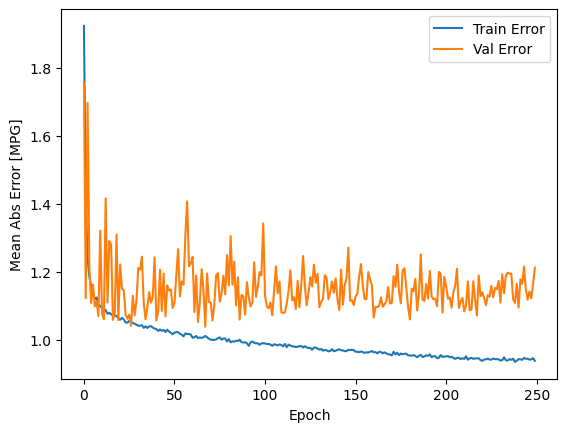

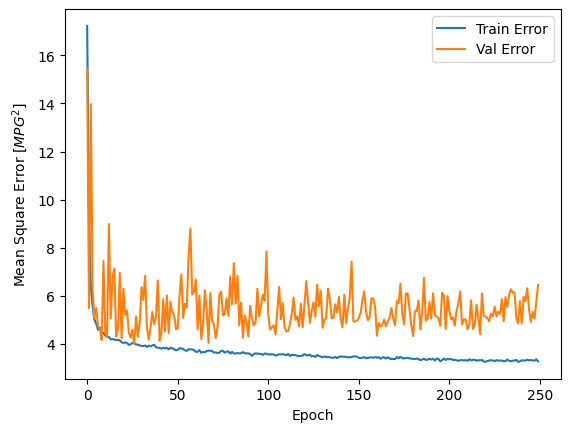

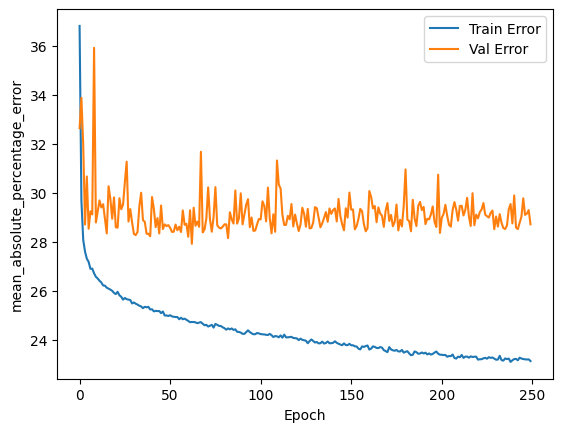

In [105]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('mean_absolute_percentage_error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [106]:
from sklearn.metrics import mean_absolute_percentage_error,median_absolute_error
mae_train = median_absolute_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mae_test = median_absolute_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [107]:
print("median absolute error")
print("entrenamiento:",mae_train,"validacion:",mae_test)

median absolute error
entrenamiento: 0.08 validacion: 0.08


In [108]:
from sklearn.metrics import mean_absolute_percentage_error,median_absolute_error
mape_train = mean_absolute_percentage_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mape_test = mean_absolute_percentage_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [109]:
print("mean absolute percentage error")
print("entrenamiento:",mape_train,"validacion:",mape_test)

mean absolute percentage error
entrenamiento: 0.23 validacion: 0.29


In [110]:
resultTest=pd.DataFrame()
resultTest["esperado"]=Y_train
resultTest["predicho"]=Y_train_pred

In [111]:
resultTest.sample(10)

,esperado,predicho
31834,1,1.675823
27832,1,0.999137
28700,2,0.999137
18549,2,1.888511
49318,1,0.999137
51499,1,0.999137
61441,2,0.999137
39603,1,0.999137
5043,3,2.343945
51194,1,0.999137


In [112]:
from tensorflow.keras.models import load_model

model.save('modelo-V3_1.h5')
model=load_model('modelo-V3_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# prediccion final

creamos una dataframe nuevo para predecir las posibles accidentes en medellin y sus comunas en los años 2021 y 2022

In [113]:
from datetime import datetime, timedelta
inicio = datetime(2021,1,1)
fin    = datetime(2022,12,31)

X_test_final = pd.DataFrame([inicio + timedelta(days=d) for d in range((fin - inicio).days + 1)],columns=["DIA"])
X_test_final

,DIA
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
...,...
725,2022-12-27
726,2022-12-28
727,2022-12-29
728,2022-12-30


In [114]:
X_test_final["key"]=1
clase_accidente=pd.DataFrame(train.CLASE_ACCIDENTE.unique(),columns=["CLASE_ACCIDENTE"])
clase_accidente["key"]=1
X_test_final=pd.merge(X_test_final, clase_accidente, on ='key')
X_test_final.head(10)

,DIA,key,CLASE_ACCIDENTE
0,2021-01-01,1,choque
1,2021-01-01,1,atropello
2,2021-01-01,1,caida ocupante
3,2021-01-01,1,otro
4,2021-01-01,1,volcamiento
5,2021-01-01,1,incendio
6,2021-01-02,1,choque
7,2021-01-02,1,atropello
8,2021-01-02,1,caida ocupante
9,2021-01-02,1,otro


In [115]:
numcomuna=pd.DataFrame(train.NUMCOMUNA.unique(),columns=["NUMCOMUNA"])
numcomuna["key"]=1
X_test_final=pd.merge(X_test_final, numcomuna, on ='key').drop(["key"],axis=1)
X_test_final.head(10)

,DIA,CLASE_ACCIDENTE,NUMCOMUNA
0,2021-01-01,choque,10
1,2021-01-01,choque,11
2,2021-01-01,choque,12
3,2021-01-01,choque,14
4,2021-01-01,choque,15
5,2021-01-01,choque,16
6,2021-01-01,choque,7
7,2021-01-01,choque,1
8,2021-01-01,choque,13
9,2021-01-01,choque,3


In [116]:
#dia_festivo 1 si 0 no
X_test_final["dia_festivo".upper()]=X_test_final["DIA"].apply(lambda x : str(co.is_holiday_date(x)))
#tiempo en meses desde el primer data conocido
X_test_final["t"]=X_test_final["DIA"].apply(lambda x : (pd.Timestamp(x).year-2014)*12+pd.Timestamp(x).month-7)
#dia de la semana en numero
X_test_final["dia_de_la_semana".upper()]=X_test_final["dia".upper()].apply(lambda x : str(pd.Timestamp(x).day_of_week))
#mes de ocurencia
X_test_final["MES"]=X_test_final["DIA"].apply(lambda x : str(pd.Timestamp(x).month))
#dia que ocurrio el accidente en el mes
X_test_final["dia_del_mes".upper()]=X_test_final["dia".upper()].apply(lambda x :str( pd.Timestamp(x).day))
X_test_final.drop(["DIA"],axis=1,inplace=True)
X_test_final

,CLASE_ACCIDENTE,NUMCOMUNA,DIA_FESTIVO,t,DIA_DE_LA_SEMANA,MES,DIA_DEL_MES
0,choque,10,True,78,4,1,1
1,choque,11,True,78,4,1,1
2,choque,12,True,78,4,1,1
3,choque,14,True,78,4,1,1
4,choque,15,True,78,4,1,1
...,...,...,...,...,...,...,...
70075,incendio,5,False,101,5,12,31
70076,incendio,6,False,101,5,12,31
70077,incendio,8,False,101,5,12,31
70078,incendio,9,False,101,5,12,31


aplicamos onehot encode al nuevo dataframe

In [117]:
X_test_final=pd.get_dummies(X_test_final,drop_first=True)
X_test_final.columns

Index(['t', 'CLASE_ACCIDENTE_caida ocupante', 'CLASE_ACCIDENTE_choque',
       'CLASE_ACCIDENTE_incendio', 'CLASE_ACCIDENTE_otro',
       'CLASE_ACCIDENTE_volcamiento', 'NUMCOMUNA_10', 'NUMCOMUNA_11',
       'NUMCOMUNA_12', 'NUMCOMUNA_13', 'NUMCOMUNA_14', 'NUMCOMUNA_15',
       'NUMCOMUNA_16', 'NUMCOMUNA_2', 'NUMCOMUNA_3', 'NUMCOMUNA_4',
       'NUMCOMUNA_5', 'NUMCOMUNA_6', 'NUMCOMUNA_7', 'NUMCOMUNA_8',
       'NUMCOMUNA_9', 'DIA_FESTIVO_True', 'DIA_DE_LA_SEMANA_1',
       'DIA_DE_LA_SEMANA_2', 'DIA_DE_LA_SEMANA_3', 'DIA_DE_LA_SEMANA_4',
       'DIA_DE_LA_SEMANA_5', 'DIA_DE_LA_SEMANA_6', 'MES_10', 'MES_11',
       'MES_12', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8',
       'MES_9', 'DIA_DEL_MES_10', 'DIA_DEL_MES_11', 'DIA_DEL_MES_12',
       'DIA_DEL_MES_13', 'DIA_DEL_MES_14', 'DIA_DEL_MES_15', 'DIA_DEL_MES_16',
       'DIA_DEL_MES_17', 'DIA_DEL_MES_18', 'DIA_DEL_MES_19', 'DIA_DEL_MES_2',
       'DIA_DEL_MES_20', 'DIA_DEL_MES_21', 'DIA_DEL_MES_22', 'DIA_DEL_MES_23',

In [118]:
prediccion_final=pd.DataFrame(model.predict(X_test_final))
prediccion_final

2190/2190 [==============================] - 3s 2ms/step


,0
0,0.999137
1,0.999137
2,0.999137
3,0.999137
4,0.999137
...,...
70075,0.999137
70076,0.999137
70077,0.999137
70078,0.999137



# analisis de los resultados

In [119]:
datos=pd.concat([X_train[:],X_test[:],X_test_final], ignore_index=True)

datos.shape

(155398, 69)

In [120]:
resultados=pd.concat([pd.DataFrame(Y_train_pred),pd.DataFrame(Y_test_pred),prediccion_final], ignore_index=True)
resultados.columns=["CANTIDAD_PRED",]
resultados.shape

(155398, 1)

In [121]:
datos=datos.join(resultados)
datos

,t,CLASE_ACCIDENTE_caida ocupante,CLASE_ACCIDENTE_choque,CLASE_ACCIDENTE_incendio,CLASE_ACCIDENTE_otro,CLASE_ACCIDENTE_volcamiento,NUMCOMUNA_10,NUMCOMUNA_11,NUMCOMUNA_12,NUMCOMUNA_13,...,DIA_DEL_MES_3,DIA_DEL_MES_30,DIA_DEL_MES_31,DIA_DEL_MES_4,DIA_DEL_MES_5,DIA_DEL_MES_6,DIA_DEL_MES_7,DIA_DEL_MES_8,DIA_DEL_MES_9,CANTIDAD_PRED
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,5.323990
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,2.143557
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.999137
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.915428
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.859343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155393,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.999137
155394,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.999137
155395,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.999137
155396,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.999137


In [122]:
datos["CANTIDAD_PRED"]=datos["CANTIDAD_PRED"].apply(lambda x : round(x,0))
datos

,t,CLASE_ACCIDENTE_caida ocupante,CLASE_ACCIDENTE_choque,CLASE_ACCIDENTE_incendio,CLASE_ACCIDENTE_otro,CLASE_ACCIDENTE_volcamiento,NUMCOMUNA_10,NUMCOMUNA_11,NUMCOMUNA_12,NUMCOMUNA_13,...,DIA_DEL_MES_3,DIA_DEL_MES_30,DIA_DEL_MES_31,DIA_DEL_MES_4,DIA_DEL_MES_5,DIA_DEL_MES_6,DIA_DEL_MES_7,DIA_DEL_MES_8,DIA_DEL_MES_9,CANTIDAD_PRED
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,5.0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,2.0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1.0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2.0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155393,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0
155394,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0
155395,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0
155396,101,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.0


## accidentalidad en t  meses desde el primer dato


In [123]:
meses=datos.groupby(["t"]).sum()
meses.reset_index(inplace=True)
meses

,t,CLASE_ACCIDENTE_caida ocupante,CLASE_ACCIDENTE_choque,CLASE_ACCIDENTE_incendio,CLASE_ACCIDENTE_otro,CLASE_ACCIDENTE_volcamiento,NUMCOMUNA_10,NUMCOMUNA_11,NUMCOMUNA_12,NUMCOMUNA_13,...,DIA_DEL_MES_3,DIA_DEL_MES_30,DIA_DEL_MES_31,DIA_DEL_MES_4,DIA_DEL_MES_5,DIA_DEL_MES_6,DIA_DEL_MES_7,DIA_DEL_MES_8,DIA_DEL_MES_9,CANTIDAD_PRED
0,0,220,385,1,213,69,109,73,59,48,...,0,38,47,7,43,38,51,39,37,2242.0
1,1,246,425,0,264,76,116,96,60,47,...,40,45,41,46,43,52,38,45,38,2516.0
2,2,241,422,3,244,66,117,91,57,47,...,39,38,0,42,37,37,37,35,42,2482.0
3,3,209,424,0,237,68,119,82,59,44,...,39,41,42,42,41,36,36,28,39,2398.0
4,4,199,417,0,242,76,110,78,48,51,...,37,33,0,37,45,35,44,40,38,2335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,97,496,496,496,496,496,186,186,186,186,...,96,96,96,96,96,96,96,96,96,3314.0
94,98,480,480,480,480,480,180,180,180,180,...,96,96,0,96,96,96,96,96,96,3349.0
95,99,496,496,496,496,496,186,186,186,186,...,96,96,96,96,96,96,96,96,96,3472.0
96,100,480,480,480,480,480,180,180,180,180,...,96,96,0,96,96,96,96,96,96,3284.0


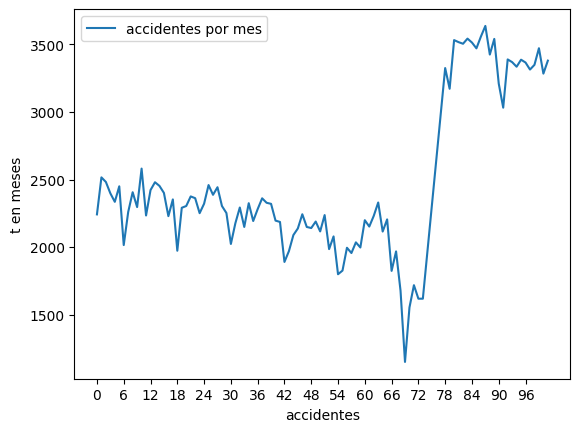

In [124]:
plt.figure()
plt.xlabel('accidentes')
plt.ylabel('t en meses')
plt.plot(meses["t"], meses["CANTIDAD_PRED"],
           label='accidentes por mes')
plt.xticks(range(0, 101, 6))
plt.legend()
plt.show()

In [125]:
resultadosesperados=pd.concat([Y_train,Y_test],ignore_index=True)
resultadosesperados

0        8
1        4
2        1
3        2
4        2
        ..
85313    2
85314    1
85315    1
85316    1
85317    1
Name: CANTIDAD, Length: 85318, dtype: int64

In [126]:
datos=datos.join(resultadosesperados)
datos

,t,CLASE_ACCIDENTE_caida ocupante,CLASE_ACCIDENTE_choque,CLASE_ACCIDENTE_incendio,CLASE_ACCIDENTE_otro,CLASE_ACCIDENTE_volcamiento,NUMCOMUNA_10,NUMCOMUNA_11,NUMCOMUNA_12,NUMCOMUNA_13,...,DIA_DEL_MES_30,DIA_DEL_MES_31,DIA_DEL_MES_4,DIA_DEL_MES_5,DIA_DEL_MES_6,DIA_DEL_MES_7,DIA_DEL_MES_8,DIA_DEL_MES_9,CANTIDAD_PRED,CANTIDAD
0,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,5.0,8.0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,2.0,4.0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1.0,1.0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2.0,2.0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155393,101,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1.0,NaN
155394,101,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1.0,NaN
155395,101,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1.0,NaN
155396,101,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1.0,NaN


In [127]:
meses=datos.groupby(["t"]).sum()
meses.reset_index(inplace=True)
meses

,t,CLASE_ACCIDENTE_caida ocupante,CLASE_ACCIDENTE_choque,CLASE_ACCIDENTE_incendio,CLASE_ACCIDENTE_otro,CLASE_ACCIDENTE_volcamiento,NUMCOMUNA_10,NUMCOMUNA_11,NUMCOMUNA_12,NUMCOMUNA_13,...,DIA_DEL_MES_30,DIA_DEL_MES_31,DIA_DEL_MES_4,DIA_DEL_MES_5,DIA_DEL_MES_6,DIA_DEL_MES_7,DIA_DEL_MES_8,DIA_DEL_MES_9,CANTIDAD_PRED,CANTIDAD
0,0,220,385,1,213,69,109,73,59,48,...,38,47,7,43,38,51,39,37,2242.0,3163.0
1,1,246,425,0,264,76,116,96,60,47,...,45,41,46,43,52,38,45,38,2516.0,3601.0
2,2,241,422,3,244,66,117,91,57,47,...,38,0,42,37,37,37,35,42,2482.0,3564.0
3,3,209,424,0,237,68,119,82,59,44,...,41,42,42,41,36,36,28,39,2398.0,3446.0
4,4,199,417,0,242,76,110,78,48,51,...,33,0,37,45,35,44,40,38,2335.0,3313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,97,496,496,496,496,496,186,186,186,186,...,96,96,96,96,96,96,96,96,3314.0,0.0
94,98,480,480,480,480,480,180,180,180,180,...,96,0,96,96,96,96,96,96,3349.0,0.0
95,99,496,496,496,496,496,186,186,186,186,...,96,96,96,96,96,96,96,96,3472.0,0.0
96,100,480,480,480,480,480,180,180,180,180,...,96,0,96,96,96,96,96,96,3284.0,0.0


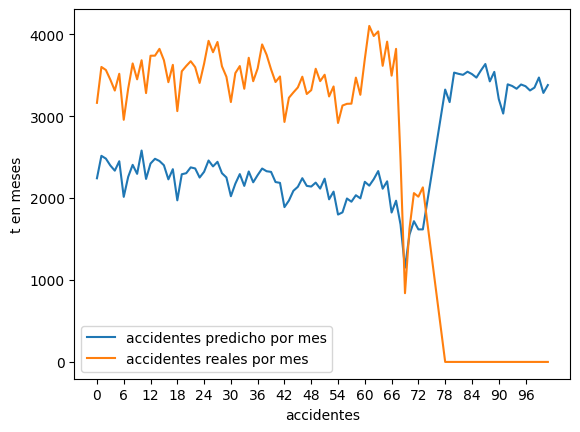

In [128]:
plt.figure()
plt.xlabel('accidentes')
plt.ylabel('t en meses')
plt.plot(meses["t"], meses["CANTIDAD_PRED"],
           label='accidentes predicho por mes')
plt.plot(meses["t"], meses["CANTIDAD"],
           label='accidentes reales por mes')
plt.xticks(range(0, 101, 6))
plt.legend()
plt.show()

podemos notar que el modelo real y el predicho tienen una forma similar entre las semanas [0,66] aproximadamente, pero discrepan en magnitud, de la semana 66 al a 72 el modelo predicho se acercamucho a los datos relaes, y despues de la semana 72 el modelo el modelo toma un  comportamiento muy extraño, pero se aprecia que se acerca a magnitud de las cantidades de accidentes por mes de los datos reales en tre las semanas 0 y 66

### accidentalidad por tipo de accidente

In [129]:
caidas=datos[datos["CLASE_ACCIDENTE_caida ocupante"]==1].groupby(["t"]).sum()
caidas.reset_index(inplace=True)
choques=datos[datos["CLASE_ACCIDENTE_choque"]==1].groupby(["t"]).sum()
choques.reset_index(inplace=True)
incendios=datos[datos["CLASE_ACCIDENTE_incendio"]==1].groupby(["t"]).sum()
incendios.reset_index(inplace=True)
otros=datos[datos["CLASE_ACCIDENTE_otro"]==1].groupby(["t"]).sum()
otros.reset_index(inplace=True)
volcamientos=datos[datos["CLASE_ACCIDENTE_volcamiento"]==1].groupby(["t"]).sum()
volcamientos.reset_index(inplace=True)


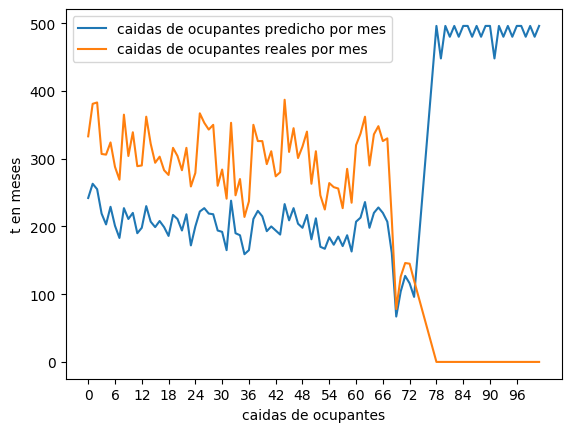

In [130]:
plt.figure()
plt.xlabel('caidas de ocupantes')
plt.ylabel('t en meses')
plt.plot(caidas["t"], caidas["CANTIDAD_PRED"],
           label='caidas de ocupantes predicho por mes')
plt.plot(caidas["t"], caidas["CANTIDAD"],
           label='caidas de ocupantes reales por mes')
plt.xticks(range(0, 101, 6))
plt.legend()
plt.show()

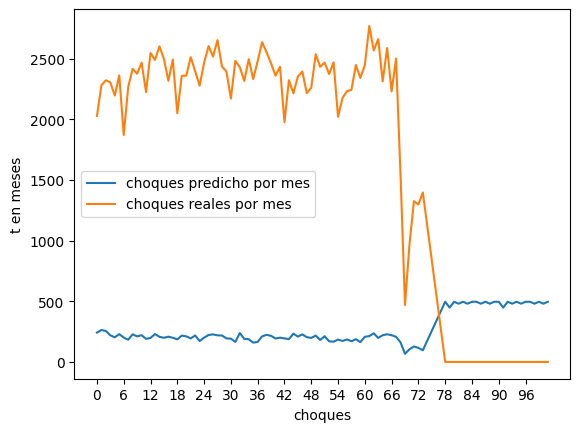

In [131]:
plt.figure()
plt.xlabel('choques')
plt.ylabel('t en meses')
plt.plot(choques["t"], caidas["CANTIDAD_PRED"],
           label='choques predicho por mes')
plt.plot(choques["t"], choques["CANTIDAD"],
           label='choques reales por mes')
plt.xticks(range(0, 101, 6))
plt.legend()
plt.show()

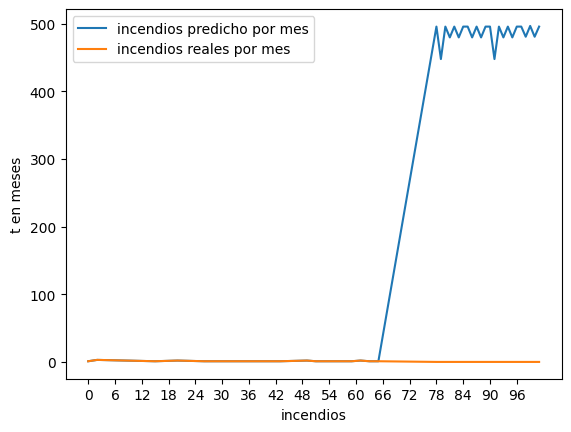

In [132]:
plt.figure()
plt.xlabel('incendios')
plt.ylabel('t en meses')
plt.plot(incendios["t"], incendios["CANTIDAD_PRED"],
           label='incendios predicho por mes')
plt.plot(incendios["t"], incendios["CANTIDAD"],
           label='incendios reales por mes')
plt.xticks(range(0, 101, 6))
plt.legend()
plt.show()

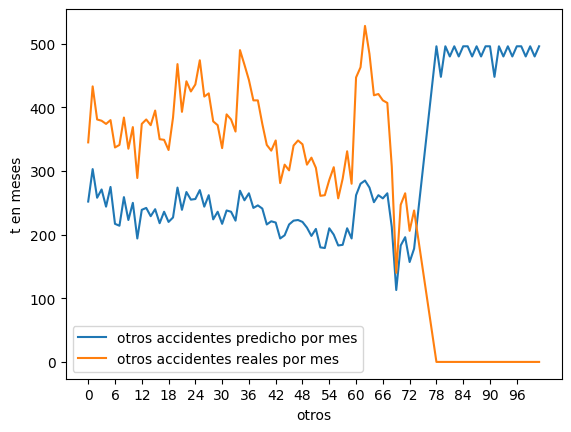

In [133]:
plt.figure()
plt.xlabel('otros')
plt.ylabel('t en meses')
plt.plot(otros["t"], otros["CANTIDAD_PRED"],
           label='otros accidentes predicho por mes')
plt.plot(otros["t"], otros["CANTIDAD"],
           label='otros accidentes reales por mes')
plt.xticks(range(0, 101, 6))
plt.legend()
plt.show()

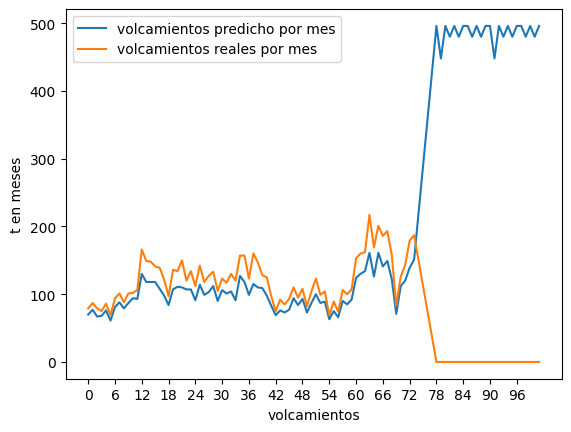

In [134]:
plt.figure()
plt.xlabel('volcamientos')
plt.ylabel('t en meses')
plt.plot(volcamientos["t"], volcamientos["CANTIDAD_PRED"],
           label='volcamientos predicho por mes')
plt.plot(volcamientos["t"], volcamientos["CANTIDAD"],
           label='volcamientos reales por mes')
plt.xticks(range(0, 101, 6))
plt.legend()
plt.show()

como notamos en la anteriror aprecicacion en todos los tipos de choque el modelo toma un compartamiento atipico despues de la semana 72, tambien notamos que eltipo de accidente volcamientos es el que mejor predice el modelo, junto con incendios y en el que tiene un peor rendimiento es en choques

In [135]:
X_test_final

,t,CLASE_ACCIDENTE_caida ocupante,CLASE_ACCIDENTE_choque,CLASE_ACCIDENTE_incendio,CLASE_ACCIDENTE_otro,CLASE_ACCIDENTE_volcamiento,NUMCOMUNA_10,NUMCOMUNA_11,NUMCOMUNA_12,NUMCOMUNA_13,...,DIA_DEL_MES_29,DIA_DEL_MES_3,DIA_DEL_MES_30,DIA_DEL_MES_31,DIA_DEL_MES_4,DIA_DEL_MES_5,DIA_DEL_MES_6,DIA_DEL_MES_7,DIA_DEL_MES_8,DIA_DEL_MES_9
0,78,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,78,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,78,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,78,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70075,101,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
70076,101,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
70077,101,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
70078,101,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
